# Generative Adversarial Network

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import math
from skimage.io import imsave
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.4 * 2, 4.8 * 2)

In [2]:
def weight_bias(shape, name):
  w = tf.Variable(tf.truncated_normal(shape=shape, stddev=1.0 / math.sqrt(shape[0])), name=name % 'w')
  b = tf.Variable(tf.constant(0.1, shape=[shape[1]]), name=name % 'b')
  
  return w, b

def generator(z_prior):
  w1, b1 = weight_bias([z_size, h1_size], name='g_%s1')
  w2, b2 = weight_bias([h1_size, h2_size], name='g_%s2')
  w3, b3 = weight_bias([h2_size, img_size], name='g_%s3')
  g_params = [w1, b1, w2, b2, w3, b3]
  
  h1 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(z_prior, w1) + b1), keep_prob)
  h2 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(h1, w2) + b2), keep_prob)
  h3 = tf.nn.tanh(tf.matmul(h2, w3) + b3)
  x_generated = h3
  
  return x_generated, g_params

def discriminator(x_data, x_generated, keep_prob):
  w1, b1 = weight_bias([img_size, h2_size], name='d_%s1')
  w2, b2 = weight_bias([h2_size, h1_size], name='d_%s2')
  w3, b3 = weight_bias([h1_size, 1], name='d_%s3')
  d_params = [w1, b1, w2, b2, w3, b3]
  
  x_in = tf.concat([x_data, x_generated], 0)
  h1 = tf.nn.leaky_relu(tf.matmul(x_in, w1) + b1)
  h2 = tf.nn.leaky_relu(tf.matmul(h1, w2) + b2)
  h3 = tf.matmul(h2, w3) + b3
  
  y_data = tf.nn.sigmoid(tf.slice(h3, [0, 0], [batch_size, -1], name=None))
  y_generated = tf.nn.sigmoid(tf.slice(h3, [batch_size, 0], [-1, -1], name=None))

  return y_data, y_generated, d_params

def show_result(batch_res, fname, grid_size=(8, 8), grid_pad=5):
  batch_res = 0.5 * batch_res.reshape((batch_res.shape[0], img_height, img_width)) + 0.5
  img_h, img_w = batch_res.shape[1], batch_res.shape[2]
  grid_h = img_h * grid_size[0] + grid_pad * (grid_size[0] - 1)
  grid_w = img_w * grid_size[1] + grid_pad * (grid_size[1] - 1)
  img_grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
  
  for i, res in enumerate(batch_res):
    if i >= grid_size[0] * grid_size[1]:
      break
    img = (res) * 255
    img = img.astype(np.uint8)
    row = (i // grid_size[0]) * (img_h + grid_pad)
    col = (i % grid_size[1]) * (img_w + grid_pad)
    img_grid[row:row + img_h, col:col + img_w] = img
    
  imsave(fname, img_grid)

### Load data

In [3]:
data_path = os.path.expanduser('~/Datasets/mnist')
mnist = input_data.read_data_sets(data_path, one_hot=True)

Extracting /Users/v-shmyhlo/Datasets/mnist/train-images-idx3-ubyte.gz
Extracting /Users/v-shmyhlo/Datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/v-shmyhlo/Datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/v-shmyhlo/Datasets/mnist/t10k-labels-idx1-ubyte.gz


### Build a graph

In [4]:
img_height = 28
img_width = 28
img_size = img_height * img_width
h1_size = 150
h2_size = 300
z_size = 100
batch_size = 256

x_data = tf.placeholder(tf.float32, [batch_size, img_size], name='x_data')
z_prior = tf.placeholder(tf.float32, [batch_size, z_size], name='z_prior')
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
global_step = tf.Variable(0, name='global_step', trainable=False)

x_generated, g_params = generator(z_prior)
y_data, y_generated, d_params = discriminator(x_data, x_generated, keep_prob)

d_loss = -tf.reduce_mean(tf.log(y_data) + tf.log(1 - y_generated))
g_loss = -tf.reduce_mean(tf.log(y_generated))

with tf.name_scope('summaries'):
  tf.summary.scalar('d_loss', d_loss)
  tf.summary.scalar('g_loss', g_loss)
  tf.summary.scalar('loss', d_loss + g_loss)
  tf.summary.scalar('learning_rate', learning_rate)

d_train = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_params)
g_train = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_params)

merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Train

In [7]:
restore = True
output_path = os.path.join('output', 'gan')
log_path = os.path.join('tf_log', 'gan')
model_name = os.path.join(log_path, 'model')
n_steps = 100001
log_interval = 200
save_interval = 1000
d_steps = 2
g_steps = 1
kp = 0.75
lr = 3e-5

def normalize_image(x):
  return x * 2 - 1

with tf.Session() as sess:
  train_writer = tf.summary.FileWriter(os.path.join(log_path, 'train'), sess.graph)
  
  if restore:
    chkpt_fname = tf.train.latest_checkpoint(log_path)
    saver.restore(sess, chkpt_fname)
  else:
    sess.run(init)
    if os.path.exists(output_path):
      shutil.rmtree(output_path)
    os.mkdir(output_path)

  z_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
  
  for i in range(sess.run(global_step), n_steps):
    x_train = normalize_image(mnist.train.next_batch(batch_size)[0])
    z_value = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
    
    for k in range(d_steps):
      sess.run(d_train,
               feed_dict={x_data: x_train, z_prior: z_value, keep_prob: kp, learning_rate: lr})

    for k in range(g_steps):
      sess.run(g_train,
               feed_dict={x_data: x_train, z_prior: z_value, keep_prob: kp, learning_rate: lr})
        
    if i % log_interval == 0:
      g_l, d_l, summary = sess.run([g_loss, d_loss, merged], 
                          feed_dict={x_data: normalize_image(mnist.validation.images[:batch_size]), 
                                     z_prior: z_sample_val, 
                                     keep_prob: 1,
                                     learning_rate: lr})
      print('step: %d/%d, loss: %f (g_loss: %f, d_loss: %f)' % 
            (i, n_steps, g_l + d_l, g_l, d_l))

      train_writer.add_summary(summary, i)
      train_writer.flush()
    
    if i % save_interval == 0:
      x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_sample_val, keep_prob: 1})
      show_result(x_gen_val, os.path.join(output_path, 'sample%s.jpg' % i))

      z_random_sample_val = np.random.normal(0, 1, size=(batch_size, z_size)).astype(np.float32)
      x_gen_val = sess.run(x_generated, feed_dict={z_prior: z_random_sample_val, keep_prob: 1})
      show_result(x_gen_val, os.path.join(output_path, 'random_sample%s.jpg' % i))

      sess.run(tf.assign(global_step, i + 1))
      save_path = saver.save(sess, model_name, global_step=global_step)
      print('model saved: %s' % save_path)

INFO:tensorflow:Restoring parameters from tf_log/gan/model-90001
step: 90200/100001, loss: 4.917664 (g_loss: 4.452601, d_loss: 0.465062)
step: 90400/100001, loss: 3.543997 (g_loss: 3.149873, d_loss: 0.394124)
step: 90600/100001, loss: 3.733387 (g_loss: 3.365060, d_loss: 0.368326)
step: 90800/100001, loss: 3.665957 (g_loss: 3.257121, d_loss: 0.408835)
step: 91000/100001, loss: 3.874290 (g_loss: 3.479291, d_loss: 0.394999)
model saved: tf_log/gan/model-91001
step: 91200/100001, loss: 3.806484 (g_loss: 3.414389, d_loss: 0.392095)
step: 91400/100001, loss: 4.063063 (g_loss: 3.686374, d_loss: 0.376688)
step: 91600/100001, loss: 4.102274 (g_loss: 3.702797, d_loss: 0.399477)
step: 91800/100001, loss: 3.716364 (g_loss: 3.318370, d_loss: 0.397994)
step: 92000/100001, loss: 4.109738 (g_loss: 3.734381, d_loss: 0.375357)
model saved: tf_log/gan/model-92001
step: 92200/100001, loss: 4.292994 (g_loss: 3.885935, d_loss: 0.407059)
step: 92400/100001, loss: 3.653472 (g_loss: 3.218459, d_loss: 0.435014)

### Visualize

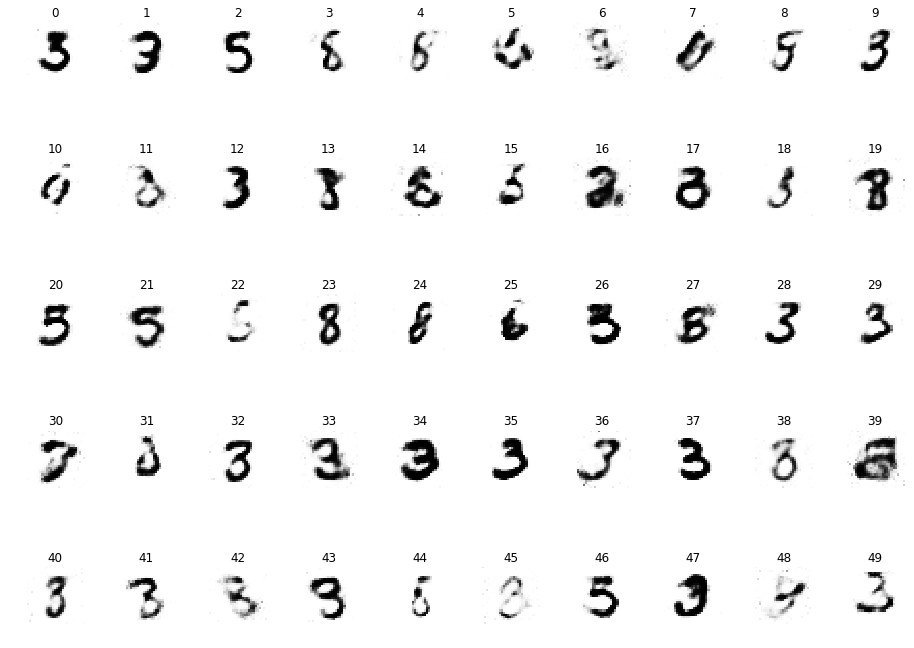

In [8]:
n_rows = 5
n_columns = 10
n_samples = n_rows * n_columns
x = x_gen_val[:n_samples].reshape(-1, img_height, img_width)
fig = plt.figure()
cmap = 'binary'

for r in range(n_rows):
  for c in range(n_columns):
    n = r * n_columns + c
    a = fig.add_subplot(n_rows, n_columns, n + 1)
    a.set_title(n)
    implot = plt.imshow(x[n, :, :])
    implot.set_cmap(cmap)
    plt.axis('off')

fig.tight_layout()